# Prepare candidate sites for VHR CHM change analysis

#### multi-decadal vegetation structure change in the Arctic
Candidate sites are those:  
1. for which we want to assess shrub change  
2. have t1 and t2 VHR imagery  

Paul Montesano  
Jordan Caraballo-Vega  
Matthew Macander  
Mark Carroll    
Glenn Tamkin  
Caleb Spradlin  

Repositories:  
https://github.com/nasa-nccs-hpda/above-shrubs.git

`Main Components:`  
 - Demonstrate the `candidate site` selection, which should have a VHR time series  

`Motivations:`

 - need to assess ability to quantify shrub change from VHR CHM time series

`Notes:`  

In [4]:
import os
import pandas as pd
import glob
import geopandas as gpd
import sys
sys.path.append('/home/pmontesa/code/evhr')
sys.path.append('/home/pmontesa/code/icesat2_boreal/lib')
import maplib_folium

import matplotlib.pyplot as plt


import requests
import ipywidgets
import IPython.display
import contextily as ctx

/tmp/ipykernel_648034/3518051425.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


### Function to select polys of a gdf with another

In [96]:
def gdf_selection(gdf1, gdf2):
    return gdf1[gdf1.geometry.apply(lambda x: any(x.intersects(y) for y in gdf2.geometry))]

# Demonstrate `candidate site` selection with VHR time series

## Suggest `candidate sites` that will be used to select VHR to see if there is a time series

We want to identify candidtate sites for studying multi-decadal vegetation structure change. These sites should have both `old` and `new` data to complete a multi-decadal time series.  
  
##### Notes  
 - https://docs.google.com/document/d/17gaIal1czeee1b09FixWu0GKAWVvR2yodU9fmwKuGXE/edit  
 - https://github.com/nasa-nccs-hpda/above-shrubs/blob/00c895e5dc4da4c6ba4e1fab2b1b59bfabdc2376/notebooks/Subset_Latest_NGA_Footprints.ipynb  
 - JJ squares classified:  mmacande/srlite/ecotype_model/20240116_JJsquares_meco2

In [5]:
dir_prj_pmm = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs'

In [6]:
# most recent 
footprint_chm = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/chm/20231014_chm/dm_10m/footprints/footprints_chm_20231023_vhrmeta.gpkg'
footprint_chm = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/footprints/footprints_20231014_chm.gpkg' # footprint_predictions.ipynb

In [7]:
MAINDIR = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs'

In [53]:
sibbork_sites = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/projects/above_tte/LC2021_cmip6/input/footprints_LCunmasked.gpkg').to_crs(4326)
jj_squares = gpd.read_file(f'{dir_prj_pmm}/data/arc/footprints_jjsquare_vhrdata.gpkg')
jj_squares['name'] = 'jj_'+jj_squares.index.astype(str).str.pad(4, fillchar='0')
candidate_site_cols = ['name','file','area_km2','area_ha','geometry']
candidate_sites = pd.concat([sibbork_sites[candidate_site_cols], jj_squares[candidate_site_cols]])

In [54]:
jj_squares.explore(tiles='http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}',attr=' ')

In [55]:
candidate_sites.to_file(os.path.join(MAINDIR, 'footprints','footprints_candidate_sites.gpkg'), driver='GPKG')

In [56]:
candidate_sites[candidate_sites.name == 'jj_0011'].file.to_list()

['WV02_20190705_M1BS_1030010094740A00-sr-02m-jj-square.tif']

## Identify potential VHR to match with `candidate sites`

In [57]:
FOOT_DATE_STR_LIST = ['20240202', '20231027']
FOOT_DATE_STR = '20240202'

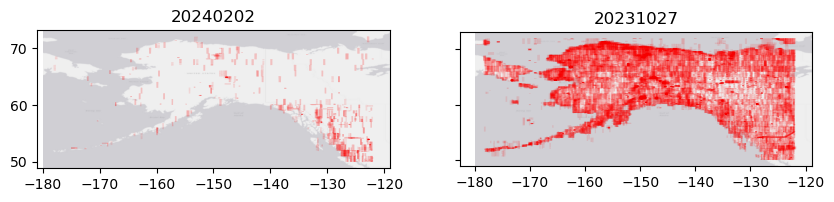

In [58]:
# VHR footprints geodataframe - selected from NGA dB by MJM
fig,axes = plt.subplots(1,2, sharey=True, figsize=(10,3))
for i, ax in enumerate(axes):
    vhr_gdf = gpd.read_file(os.path.join(MAINDIR, 'footprints', f'nga_footprint_{FOOT_DATE_STR_LIST[i]}_subset_ak_filtered.gpkg'))
    vhr_gdf['year'] = vhr_gdf['acq_year'].apply(str)

    VHR_COLS_LIST = ['geometry','catid','sensor','acq_year','acq_month','year','cloudcover','avsunazim','min_added_date', 'max_added_date']
    vhr_gdf = vhr_gdf[VHR_COLS_LIST]

    ax = vhr_gdf.cx[-178:-110,40:80].plot(ax=ax, color='red', alpha=0.1, figsize=(5,4))
    ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ')
    ax.title.set_text(FOOT_DATE_STR_LIST[i])

CPU times: user 6.58 s, sys: 95.8 ms, total: 6.68 s
Wall time: 6.69 s


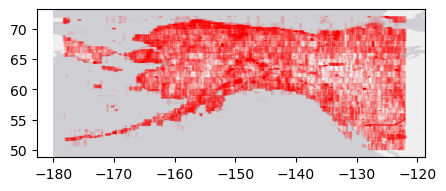

In [23]:
%%time
ax = vhr_gdf.cx[-178:-110,40:80].plot(color='red', alpha=0.1, figsize=(5,4))
ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ')

### Select all VHR at `candidate sites`

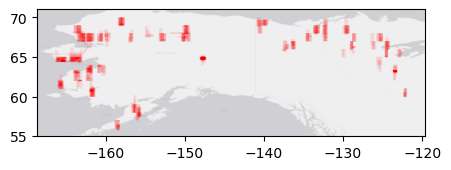

In [99]:
#vhr_gdf_selection = gpd.sjoin(vhr_gdf, candidate_sites, op='intersects', how='left').dropna(subset=['index_right'])
vhr_gdf_selection = gdf_selection(vhr_gdf, candidate_sites.to_crs(vhr_gdf.crs))
ax = vhr_gdf_selection.cx[-178:-110,40:80].plot(color='red', alpha=0.1, figsize=(5,4))
ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ')

In [152]:
YEAR_OLD_THRESH_OLD = 2009
YEAR_OLD_THRESH_NEW = 2017
MONTH_LIST = [7,8]
COLS_DROP_LIST = ['min_added_date', 'max_added_date']

### Use candidate sites to select old data ($VHR_{t1}$)

In [153]:
#vhr_gdf_selection_old = gpd.sjoin(vhr_gdf_selection[vhr_gdf_selection.acq_year < YEAR_OLD_THRESH_OLD].dropna(subset=['index_right']).drop(['index_right'], axis=1), candidate_sites, op='intersects', how='left')
vhr_gdf_selection_old = gdf_selection(vhr_gdf_selection[(vhr_gdf_selection.acq_year < YEAR_OLD_THRESH_OLD) & (vhr_gdf_selection.acq_month.isin(MONTH_LIST))], candidate_sites)

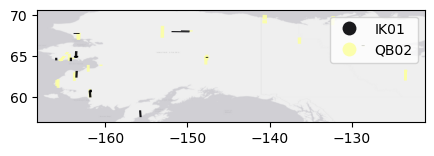

In [154]:
ax = vhr_gdf_selection_old.plot(column='sensor', cmap='inferno', alpha=0.9, figsize=(5,4), legend=True)
ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ')

In [155]:
vhr_gdf_selection_old.shape

(50, 10)

### Map all $VHR_{t1}$ at candidate sites

In [156]:
m = vhr_gdf_selection_old.drop(COLS_DROP_LIST, axis=1).explore(column='sensor', cmap='inferno', legend=True, tiles=maplib_folium.tiler_basemap_image, attr=' ', legend_kwds={'location': 'top left'})
candidate_sites.explore(color='red', m=m)

In [14]:
# # Manually target a pre-2006 CATID with a selection string that you find by manually mousing over the footprints in the map above - no need for the memorize and copy the full CATID - just the last 8 digits!
# CATID_SELECTION_STR = "10025793"
# vhr_gdf_targetcatid = vhr_gdf[vhr_gdf['catid'].str.contains(CATID_SELECTION_STR)].drop(['min_added_date', 'max_added_date'], axis=1)
# CATID = vhr_gdf_targetcatid.catid.to_list()[0]
# vhr_gdf_targetcatid.iloc[0]

In [15]:
#vhr_gdf_selection_new = vhr_gdf_selection.dropna(subset=['bands_right'])[vhr_gdf_selection.columns.drop(list(vhr_gdf_selection.filter(regex='_right')))]

### Use candidate sites to select new $VHR_{t2}$

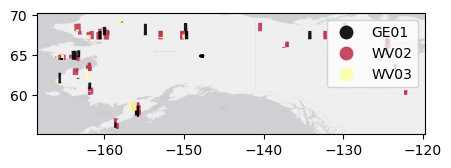

In [157]:
#vhr_gdf_selection_new = gpd.sjoin(vhr_gdf_selection[vhr_gdf_selection.acq_year > YEAR_OLD_THRESH_NEW].dropna(subset=['index_right']).drop(['index_right'], axis=1), candidate_sites, op='intersects', how='left')
vhr_gdf_selection_new = gdf_selection(vhr_gdf_selection[(vhr_gdf_selection.acq_year > YEAR_OLD_THRESH_NEW) & (vhr_gdf_selection.acq_month.isin(MONTH_LIST)) ], candidate_sites)
ax = vhr_gdf_selection_new.plot(column='sensor', cmap='inferno', alpha=0.9, figsize=(5,4), legend=True)
ctx.add_basemap(ax=ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ')

In [158]:
vhr_gdf_selection_new.shape

(303, 10)

### Map all $VHR_{t2}$ at candidate sites

In [159]:
m = vhr_gdf_selection_new.drop(COLS_DROP_LIST, axis=1).explore(column='sensor', cmap='inferno', legend=True, tiles=maplib_folium.tiler_basemap_image, attr=' ')
#m = vhr_gdf_targetcatid.explore(m=m, color='red')
candidate_sites.explore(color='red', m=m)

### Find candidate sites that have $VHR_{t1}$ and $VHR_{t2}$

In [160]:
COLS_DROP = list(vhr_gdf_selection_new.filter(regex='_left')) + list(vhr_gdf_selection_new.filter(regex='_right'))

In [161]:
candidate_sites_t1 = gpd.sjoin(candidate_sites, vhr_gdf_selection_old.drop(COLS_DROP, axis=1), op='intersects', how='left').dropna(subset=['sensor'])
candidate_sites_t2 = gpd.sjoin(candidate_sites, vhr_gdf_selection_new.drop(COLS_DROP, axis=1), op='intersects', how='left').dropna(subset=['sensor'])

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


## Build final database of all t1 and t2 pairs for all candidate sites

In [162]:
candidate_sites_t1_t2 = gpd.sjoin(candidate_sites_t1.drop('index_right', axis=1), vhr_gdf_selection_new.drop(COLS_DROP, axis=1), op='intersects', how='left')
candidate_sites_t1_t2['year_delta'] = candidate_sites_t1_t2['acq_year_right'] - candidate_sites_t1_t2['acq_year_left']

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [166]:
candidate_sites_t1_t2.to_file(f'{dir_prj_pmm}/data/arc/candidate_sites_t1t2_db.gpkg', driver='GPKG', mode='w')

## At a candidate site, map all t2 strips associated with a t1 `catid`

**not sure if this is useful**

In [113]:
def rm_datetime_cols(gdf, type_str="datetime64[ns, UTC]"):
    return list(set(gdf.columns) - set(gdf.select_dtypes(include=type_str).columns))

In [114]:
cand_site_name = 'jj_0011'

In [211]:
cand_site = candidate_sites_t1_t2[candidate_sites_t1_t2.name == cand_site_name]
print(cand_site.shape)
print(set(cand_site.catid_left.to_list()))

(560, 25)
{'101001000854D700', '101001000872D000', '1010010005BA1600', '10100100087A6100', '10100100052D3D00', '1010010005BCC200', '10100100052AB200'}


In [212]:
# select a t1 catid
cat_id_t1 = '101001000872D000'

In [213]:
# subset the candidates database
gdf_t1_sub = candidate_sites_t1_t2[ candidate_sites_t1_t2.catid_left == cat_id_t1]
cat_id_t2_list = gdf_t1_sub.catid_right.to_list()

In [214]:
import folium

In [217]:
style_kwds = {'fillOpacity': 0.2, 'opacity': 1}

# Map t2 imagery: TODO - check this head(1)??
m = vhr_gdf[ vhr_gdf.catid.isin(cat_id_t2_list)][rm_datetime_cols(vhr_gdf)].head(1).explore(color='yellow',style_kwds=style_kwds, name='VHR t2', legend=True, 
                                                                                           tiles='http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', 
                                                                                            attr=' ')
m = vhr_gdf[ vhr_gdf.catid == cat_id_t1][rm_datetime_cols(vhr_gdf)].explore(m=m, color='orange',style_kwds=style_kwds, name='VHR t1')
m = gdf_t1_sub[rm_datetime_cols(gdf_t1_sub)].explore(m=m, color='red', style_kwds=style_kwds, name='candidate site(s)')
folium.LayerControl().add_to(m)
m

# Candidate sites + existing CNN CHM footprints + available VHR footprints

For a given site, get the `VHR` imagery we should process to do a `change analysis`

In [168]:
candidate_sites_t1_t2 = gpd.read_file(f'{dir_prj_pmm}/data/arc/candidate_sites_t1t2_db.gpkg')
candidate_sites = gpd.read_file(os.path.join(MAINDIR, 'footprints','footprints_candidate_sites.gpkg'))

In [170]:
footprint_chm_gdf = gpd.read_file(footprint_chm)

### Select CHM footprints intersectn cgandidate site
`red` --> candidate site  
`black` --> CHMs we have that intersect cand site  
`orange` --> old VHR we need to process to CHM  
`yellow` --> new VHR we need to process to CHM


In [193]:
# Select CHMs that intersect site
footprint_chm_site_intersection = gdf_selection(footprint_chm_gdf, candidate_sites[candidate_sites.name == cand_site_name])

#### CatIDs processed to CHMs for this site

In [181]:
catids_chms_processed = footprint_site_intersection.catid.to_list()
print(len(catids_chms_processed))
footprint_site_intersection.year.to_list()

5


[2019, 2017, 2019, 2019, 2019]

### VHR data (old & new) available for this site

In [190]:
vhr_gdf_selection_old_intersection = gdf_selection(vhr_gdf_selection_old, candidate_sites[candidate_sites.name == cand_site_name])
vhr_gdf_selection_new_intersection = gdf_selection(vhr_gdf_selection_new, candidate_sites[candidate_sites.name == cand_site_name])

#### CatIDs available in archive to process to CHMs

In [185]:
catid_vhr_old = vhr_gdf_selection_old_intersection.catid.to_list()
print(len(catid_vhr_old))
vhr_gdf_selection_old_intersection.acq_year.to_list()

7


[2006, 2006, 2007, 2007, 2008, 2008, 2008]

In [197]:
catids_vhr_old_need = [x for x in catid_vhr_old if x not in catids_chms_processed]
len(catids_vhr_old_need)

7

In [198]:
catids_vhr_new = vhr_gdf_selection_new_intersection.catid.to_list()
print(len(catids_vhr_new))
print(vhr_gdf_selection_new_intersection.acq_year.to_list())

80
[2018, 2018, 2018, 2018, 2018, 2018, 2018, 2019, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2018, 2018, 2018, 2018, 2018, 2018, 2020, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2022, 2019, 2019, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2021, 2021, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022, 2022]


In [199]:
#set(catids_vhr_new) - set(catids_chms_processed)
catids_vhr_new_need = [x for x in catids_vhr_new if x not in catids_chms_processed]
len(catids_vhr_new_need)

78

### Map VHR we should process to be able to examine change

**check for cloudcover**

In [222]:
style_kwds = {'fillOpacity': 0.2, 'opacity': 1}
m = footprint_chm_site_intersection.drop('date', axis=1).explore(color='black', style_kwds=style_kwds, name='CHMs processed')
m = vhr_gdf_selection_old_intersection[vhr_gdf_selection_old_intersection.catid.isin(catids_vhr_old_need)].drop(['min_added_date','max_added_date'], axis=1).explore(color='orange', name='VHR[old] need', style_kwds=style_kwds, m=m)
m = vhr_gdf_selection_new_intersection[vhr_gdf_selection_new_intersection.catid.isin(catids_vhr_new_need)].drop(['min_added_date','max_added_date'], axis=1).explore(color='yellow', name='VHR[new] need', style_kwds=style_kwds,m=m)
m = candidate_sites[candidate_sites.name == cand_site_name].explore(m=m, color='red')
folium.LayerControl().add_to(m)
m